<a href="https://colab.research.google.com/github/laribar/bitcoinprediction/blob/main/modelo_yfinance_geral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Ordem de Compra: 381.27
Ordem de Venda: 461.00
Stock: ADBE | Intervalo: 1d
Last price: 389.61
Predictions: [415.57973532 415.57973532 415.57973532 415.57973532 415.57973532]
Alert: 🚀 Compra sugerida
Justificativa: A média das previsões futuras (415.58) é 2% maior que o preço atual (389.61). Além disso, a SMA está em 429.74, a banda superior em 478.21, e a banda inferior em 381.27. O suporte está em 374.50, a resistência em 461.00, e a LTA em 557.90. Isso indica uma tendência de alta.

Probabilidades de Atingir o Preço Alvo:
Previsão: 415.58 | Probabilidade: 99.83% | Dias: 1
Previsão: 415.58 | Probabilidade: 98.10% | Dias: 2
Previsão: 415.58 | Probabilidade: 95.48% | Dias: 3
Previsão: 415.58 | Probabilidade: 92.88% | Dias: 4
Previsão: 415.58 | Probabilidade: 90.52% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: AMD | Intervalo: 1d
Last price: 107.14
Predictions: [107.18185036 108.1191547  107.48013146 106.80091229 106.07139797]
Alert: 🔍 Acompanhar
Justificativa: A média das previsões futuras (107.13) está dentro de 2% do preço atual (107.14). A SMA está em 102.43, a banda superior em 111.74, e a banda inferior em 93.12. O suporte está em 94.73, a resistência em 116.55, a LTA em 119.85, e a LTB em 94.73. Isso sugere que o mercado está estável no momento.

Probabilidades de Atingir o Preço Alvo:
Previsão: 107.18 | Probabilidade: 50.54% | Dias: 1
Previsão: 108.12 | Probabilidade: 58.75% | Dias: 2
Previsão: 107.48 | Probabilidade: 52.51% | Dias: 3
Previsão: 106.80 | Probabilidade: 47.83% | Dias: 4
Previsão: 106.07 | Probabilidade: 43.88% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: ABNB | Intervalo: 1d
Last price: 126.15
Predictions: [124.12049794 124.32581743 124.43021738 124.43021738 124.43021738]
Alert: 🔍 Acompanhar
Justificativa: A média das previsões futuras (124.35) está dentro de 2% do preço atual (126.15). A SMA está em 135.41, a banda superior em 154.54, e a banda inferior em 116.27. O suporte está em 119.15, a resistência em 157.75, a LTA em 163.93, e a LTB em 119.15. Isso sugere que o mercado está estável no momento.

Probabilidades de Atingir o Preço Alvo:
Previsão: 124.12 | Probabilidade: 24.48% | Dias: 1
Previsão: 124.33 | Probabilidade: 33.04% | Dias: 2
Previsão: 124.43 | Probabilidade: 36.78% | Dias: 3
Previsão: 124.43 | Probabilidade: 38.50% | Dias: 4
Previsão: 124.43 | Probabilidade: 39.69% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: GOOGL | Intervalo: 1d
Last price: 162.80
Predictions: [165.85219438 165.78763961 164.55793148 164.55793148 164.55793148]
Alert: 🔍 Acompanhar
Justificativa: A média das previsões futuras (165.06) está dentro de 2% do preço atual (162.80). A SMA está em 169.96, a banda superior em 182.45, e a banda inferior em 157.48. O suporte está em 156.72, a resistência em 185.34, a LTA em 185.96, e a LTB em 156.72. Isso sugere que o mercado está estável no momento.

Probabilidades de Atingir o Preço Alvo:
Previsão: 165.85 | Probabilidade: 85.20% | Dias: 1
Previsão: 165.79 | Probabilidade: 76.53% | Dias: 2
Previsão: 164.56 | Probabilidade: 63.64% | Dias: 3
Previsão: 164.56 | Probabilidade: 61.87% | Dias: 4
Previsão: 164.56 | Probabilidade: 60.65% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: GOOG | Intervalo: 1d
Last price: 165.05
Predictions: [166.87418135 166.75587554 166.70344217 166.88145466 166.84973908]
Alert: 🔍 Acompanhar
Justificativa: A média das previsões futuras (166.81) está dentro de 2% do preço atual (165.05). A SMA está em 171.92, a banda superior em 184.36, e a banda inferior em 159.48. O suporte está em 158.80, a resistência em 187.47, a LTA em 187.78, e a LTB em 158.80. Isso sugere que o mercado está estável no momento.

Probabilidades de Atingir o Preço Alvo:
Previsão: 166.87 | Probabilidade: 73.32% | Dias: 1
Previsão: 166.76 | Probabilidade: 65.98% | Dias: 2
Previsão: 166.70 | Probabilidade: 62.78% | Dias: 3
Previsão: 166.88 | Probabilidade: 62.27% | Dias: 4
Previsão: 166.85 | Probabilidade: 60.82% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Ordem de Compra: 189.38
Ordem de Venda: 221.90
Stock: AMZN | Intervalo: 1d
Last price: 194.95
Predictions: [208.55904712 208.55904712 209.81880195 209.81880195 214.1692667 ]
Alert: 🚀 Compra sugerida
Justificativa: A média das previsões futuras (210.18) é 2% maior que o preço atual (194.95). Além disso, a SMA está em 204.17, a banda superior em 221.90, e a banda inferior em 186.44. O suporte está em 189.38, a resistência em 225.13, e a LTA em 230.42. Isso indica uma tendência de alta.

Probabilidades de Atingir o Preço Alvo:
Previsão: 208.56 | Probabilidade: 99.99% | Dias: 1
Previsão: 208.56 | Probabilidade: 99.55% | Dias: 2
Previsão: 209.82 | Probabilidade: 99.00% | Dias: 3
Previsão: 209.82 | Probabilidade: 97.80% | Dias: 4
Previsão: 214.17 | Probabilidade: 98.94% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: AEP | Intervalo: 1d
Last price: 106.21
Predictions: [103.91989964 103.87289986 103.88519989 103.86294991 103.78935001]
Alert: ⚠️ Venda sugerida
Justificativa: A média das previsões futuras (103.87) é 2% menor que o preço atual (106.21). Além disso, a SMA está em 105.37, a banda superior em 108.28, e a banda inferior em 102.46. O suporte está em 101.42, a resistência em 109.52, e a LTB em 101.42. Isso indica uma tendência de baixa.

Probabilidades de Atingir o Preço Alvo:
Previsão: 103.92 | Probabilidade: 3.81% | Dias: 1
Previsão: 103.87 | Probabilidade: 10.04% | Dias: 2
Previsão: 103.89 | Probabilidade: 14.94% | Dias: 3
Previsão: 103.86 | Probabilidade: 18.18% | Dias: 4
Previsão: 103.79 | Probabilidade: 20.09% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Stock: AMGN | Intervalo: 1d
Last price: 315.04
Predictions: [292.91315624 292.91315624 294.75505592 294.58595603 294.58595603]
Alert: ⚠️ Venda sugerida
Justificativa: A média das previsões futuras (293.95) é 2% menor que o preço atual (315.04). Além disso, a SMA está em 313.27, a banda superior em 327.37, e a banda inferior em 299.18. O suporte está em 293.93, a resistência em 335.88, e a LTB em 281.64. Isso indica uma tendência de baixa.

Probabilidades de Atingir o Preço Alvo:
Previsão: 292.91 | Probabilidade: 0.00% | Dias: 1
Previsão: 292.91 | Probabilidade: 0.04% | Dias: 2
Previsão: 294.76 | Probabilidade: 0.61% | Dias: 3
Previsão: 294.59 | Probabilidade: 1.43% | Dias: 4
Previsão: 294.59 | Probabilidade: 2.51% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Ordem de Compra: 202.59
Ordem de Venda: 245.86
Stock: ADI | Intervalo: 1d
Last price: 205.90
Predictions: [222.1190234  222.2757509  222.39376095 222.12124829 222.06909328]
Alert: 🚀 Compra sugerida
Justificativa: A média das previsões futuras (222.20) é 2% maior que o preço atual (205.90). Além disso, a SMA está em 222.13, a banda superior em 245.86, e a banda inferior em 198.41. O suporte está em 202.59, a resistência em 247.10, e a LTA em 247.10. Isso indica uma tendência de alta.

Probabilidades de Atingir o Preço Alvo:
Previsão: 222.12 | Probabilidade: 100.00% | Dias: 1
Previsão: 222.28 | Probabilidade: 99.76% | Dias: 2
Previsão: 222.39 | Probabilidade: 98.97% | Dias: 3
Previsão: 222.12 | Probabilidade: 97.58% | Dias: 4
Previsão: 222.07 | Probabilidade: 96.07% | Dias: 5
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Ordem de Compra: 314.15
Ordem de Venda: 338.89
Stock: ANSS | Intervalo: 1d
Last price: 324.63
Predictions: [331.1941375 331.1201565 331.1201565 331.1201565 331.1201565]
Alert: 🚀 Compra sugerida
Justificativa: A média das previsões futuras (331.13) é 2% maior que o preço atual (324.63). Além disso, a SMA está em 326.52, a banda superior em 338.89, e a banda inferior em 314.15. O suporte está em 314.11, a resistência em 345.00, e a LTA em 360.67. Isso indica uma tendência de alta.

Probabilidades de Atingir o Preço Alvo:
Previsão: 331.19 | Probabilidade: 87.98% | Dias: 1
Previsão: 331.12 | Probabilidade: 79.42% | Dias: 2
Previsão: 331.12 | Probabilidade: 74.87% | Dias: 3
Previsão: 331.12 | Probabilidade: 71.92% | Dias: 4
Previsão: 331.12 | Probabilidade: 69.82% | Dias: 5
--------------------------------------------------------------------------------


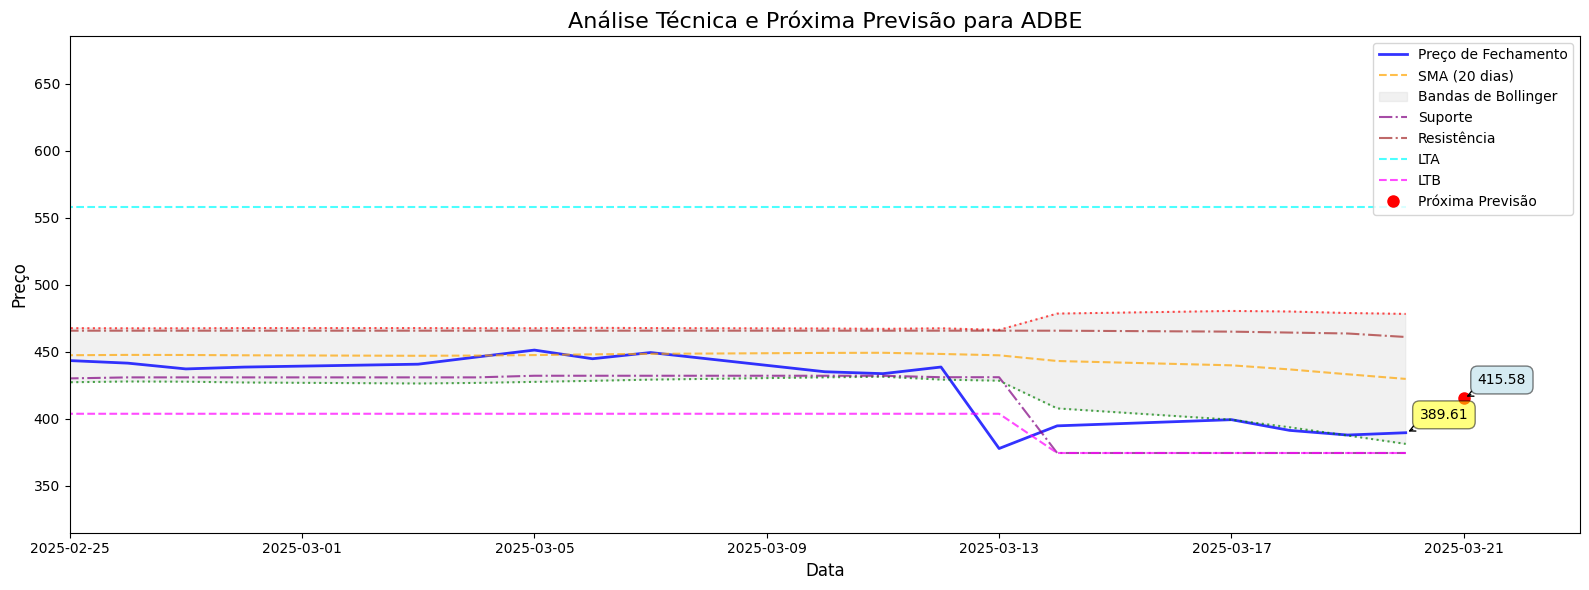

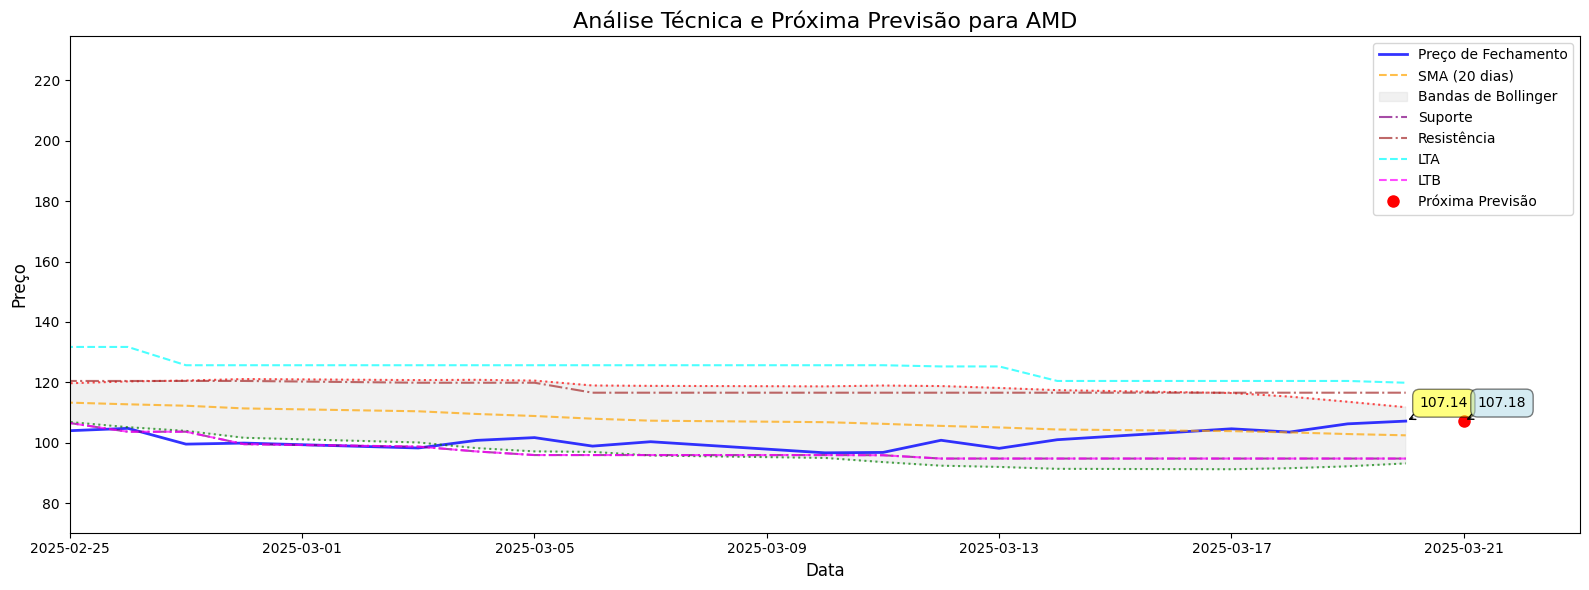

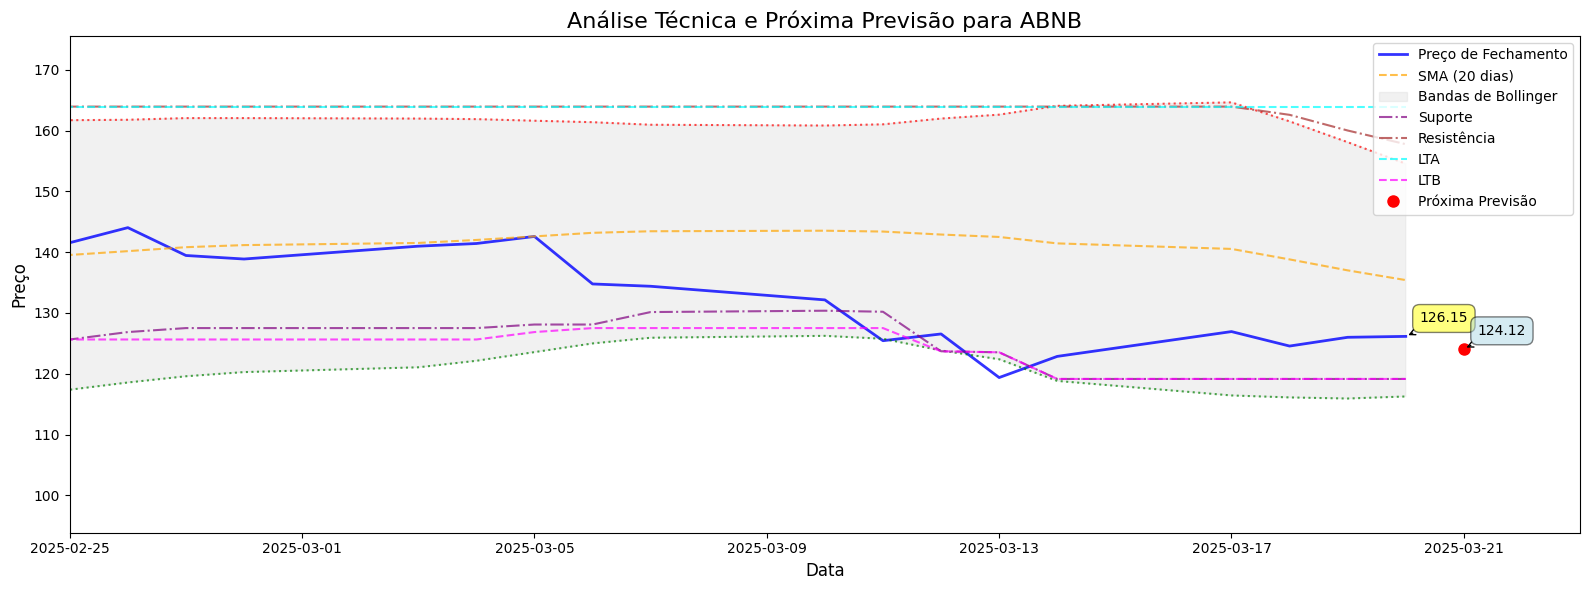

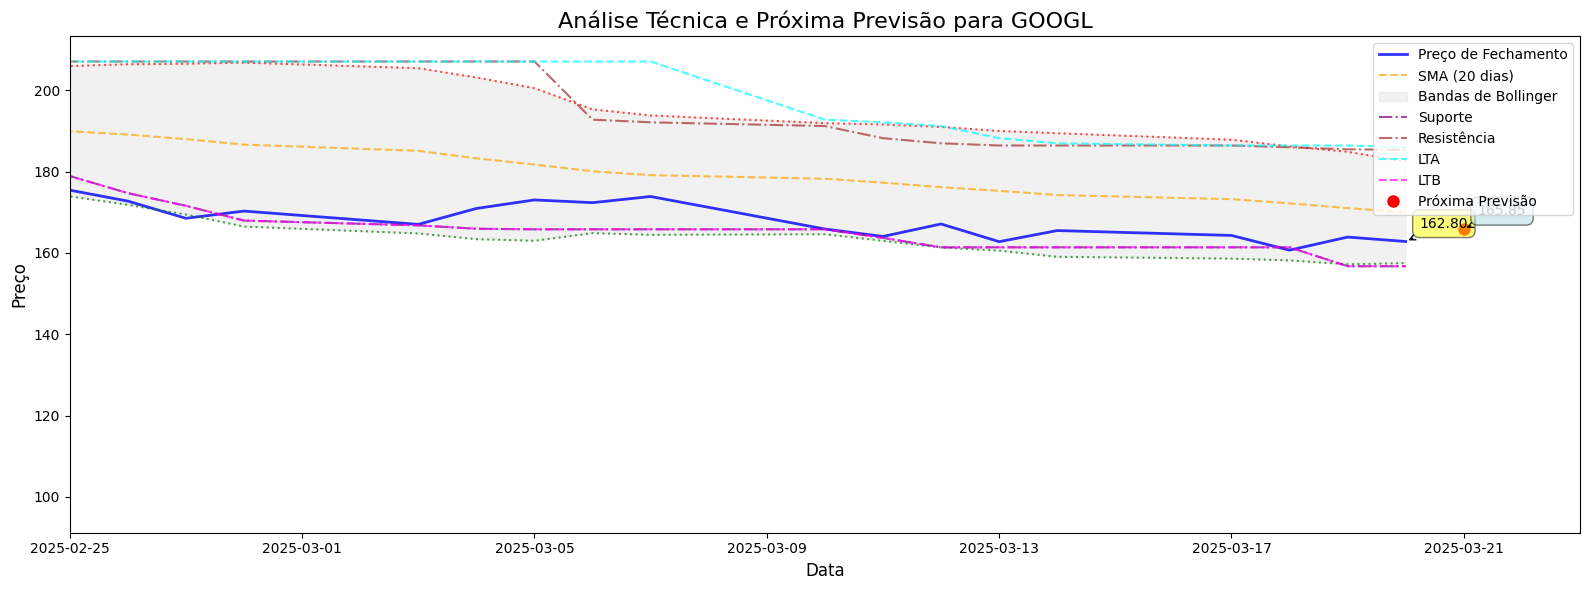

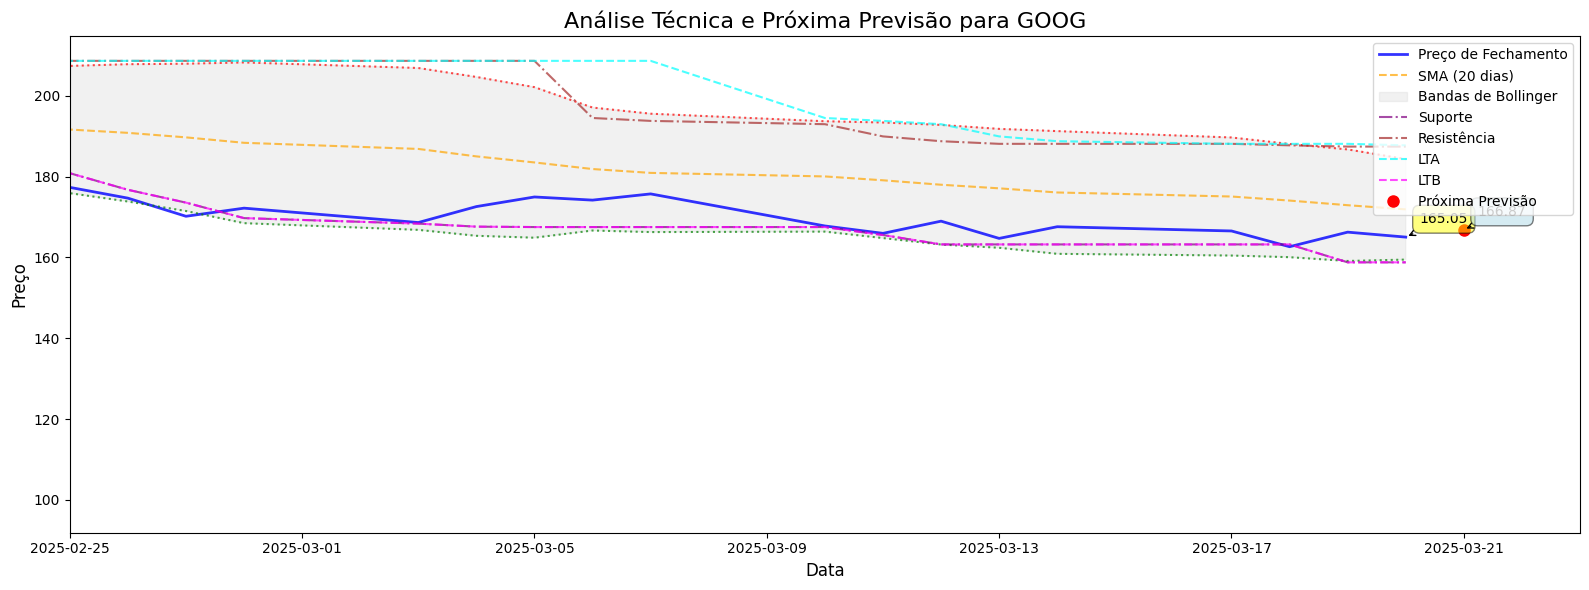

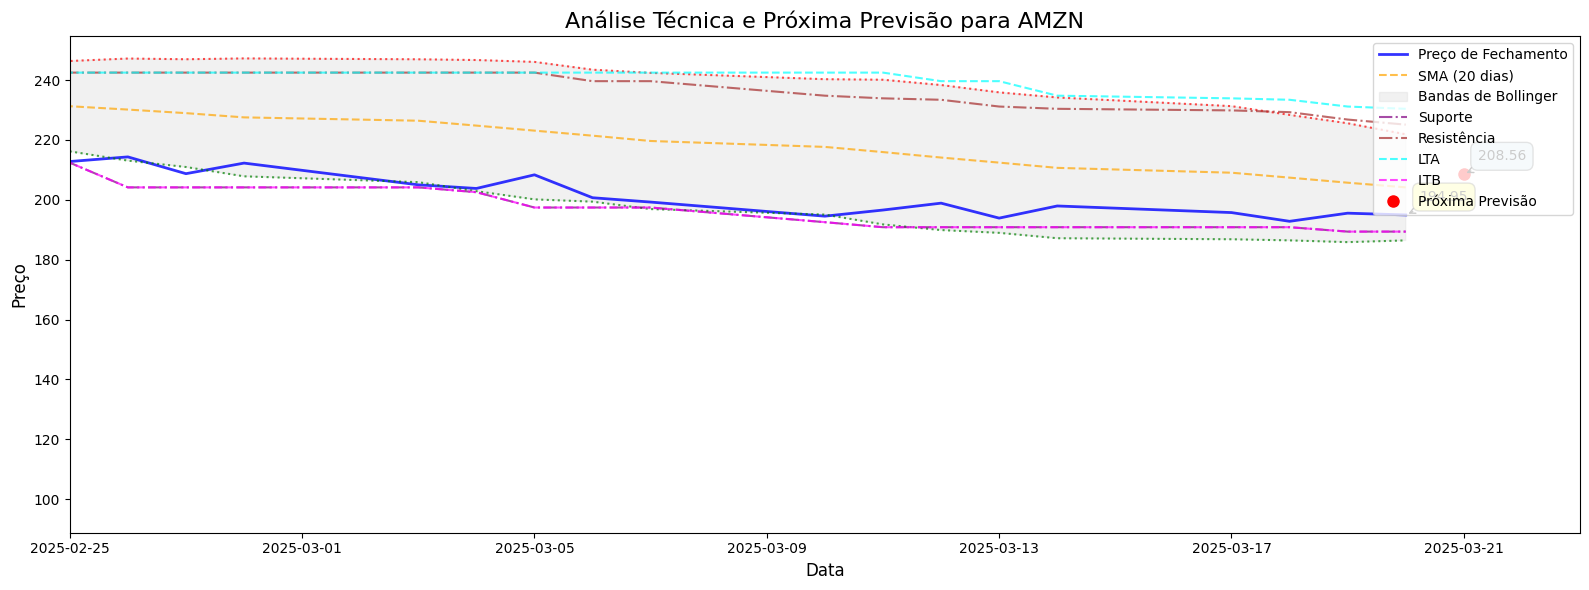

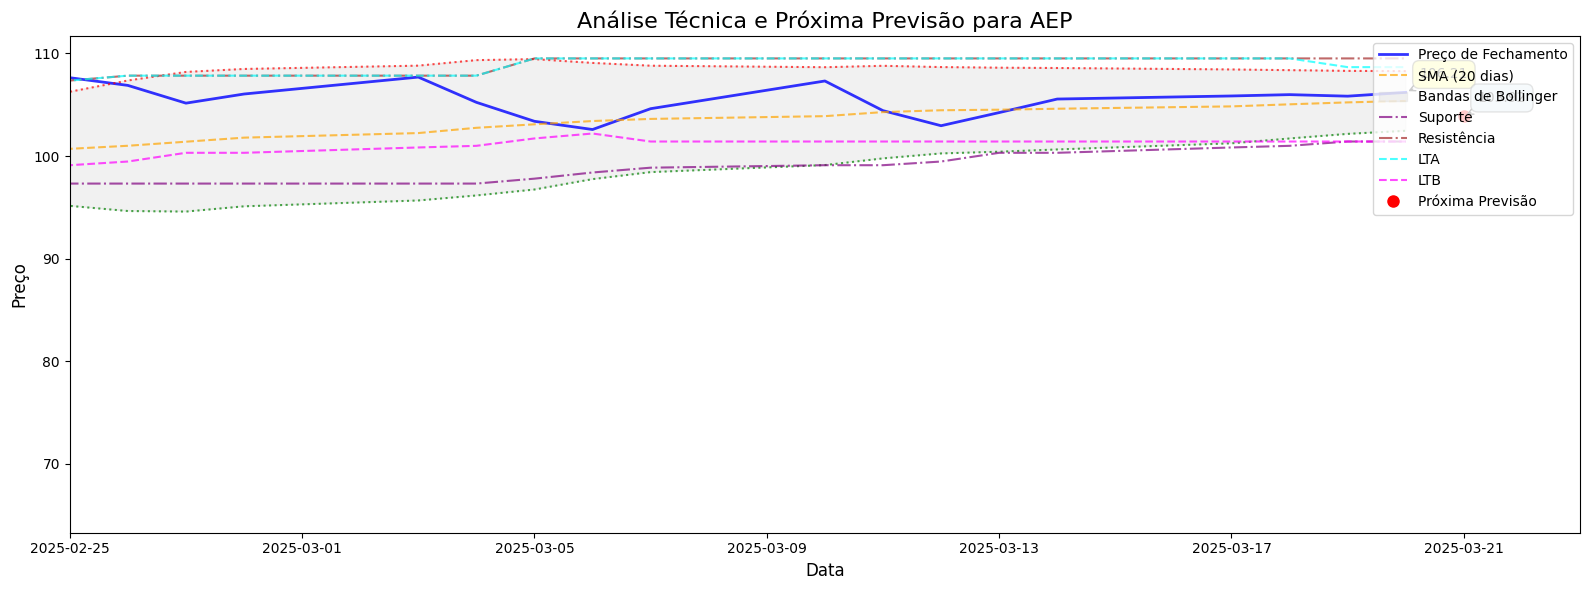

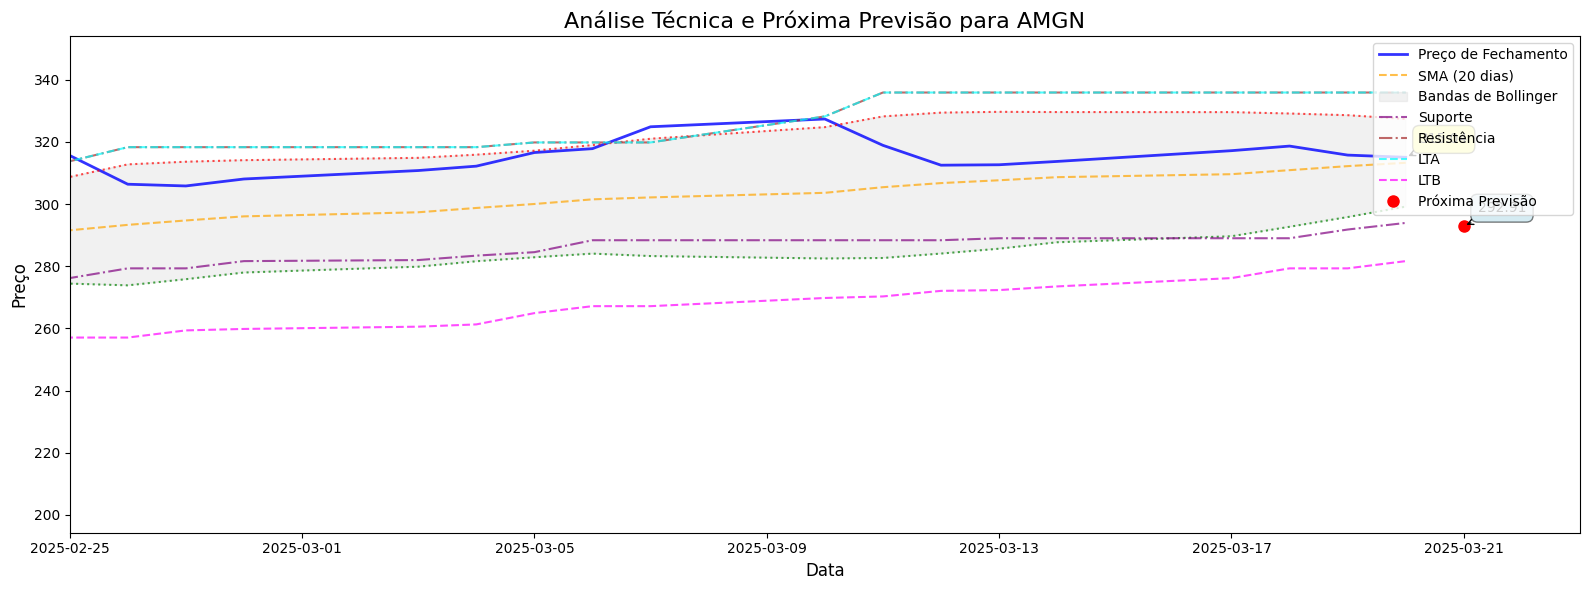

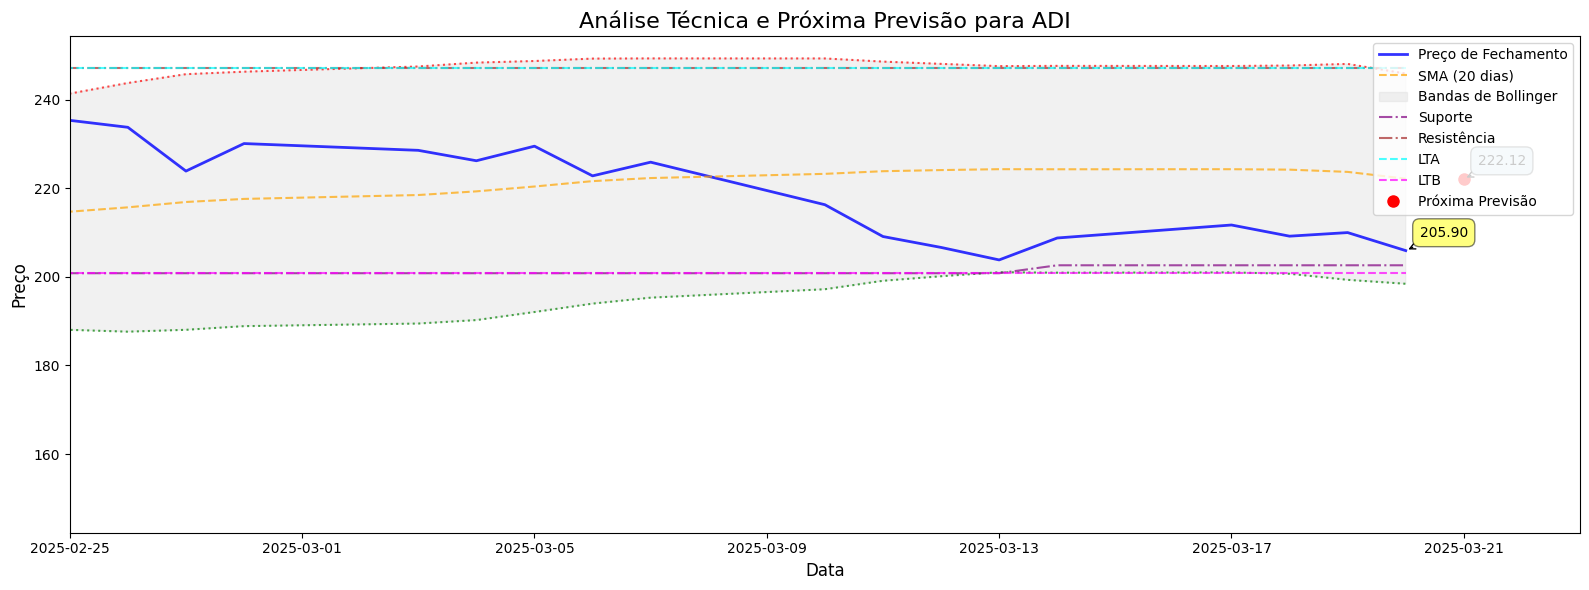

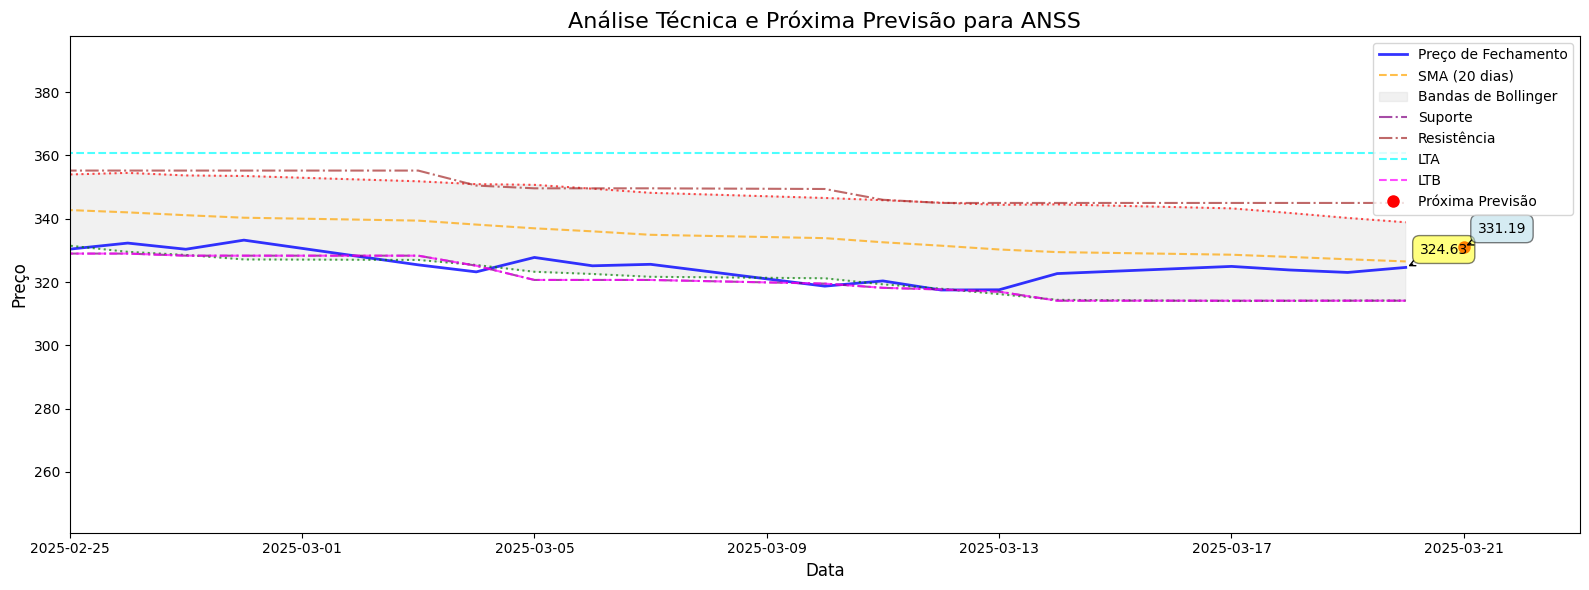

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import logging
import matplotlib.pyplot as plt
from scipy.stats import norm

# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Função para baixar dados e calcular métricas técnicas
def baixar_dados(acao, intervalo="1d", periodo="2y"):
    try:
        df = yf.download(acao, period=periodo, interval=intervalo, progress=False, auto_adjust=False)
        if df.empty or df.isnull().values.any():
            logging.error(f"Erro: Dados faltantes ou inválidos para {acao}.")
            return None

        preco_coluna = "Adj Close" if "Adj Close" in df.columns else "Close"

        if preco_coluna not in df.columns:
            logging.error(f"Erro ao processar {acao}: Nenhuma coluna de fechamento encontrada nos dados.")
            return None

        # Remove NaNs
        df.dropna(inplace=True)

        # Calcula a média móvel simples (SMA) e desvio padrão com shift para evitar forward-looking bias
        df["SMA"] = df[preco_coluna].rolling(window=20).mean().shift(1)
        df["STD"] = df[preco_coluna].rolling(window=20).std().shift(1)

        # Calcula as bandas superior e inferior
        df["Upper_Band"] = df["SMA"] + (df["STD"] * 2)
        df["Lower_Band"] = df["SMA"] - (df["STD"] * 2)

        # Calcula suporte e resistência com shift
        df["Support"] = df["Low"].rolling(window=20).min().shift(1)
        df["Resistance"] = df["High"].rolling(window=20).max().shift(1)

        # Calcula LTAs e LTBs com lookback dinâmico baseado na volatilidade
        lookback = max(10, int(df["STD"].mean() * 5))  # Ajuste baseado na volatilidade
        df["LTA"] = df["High"].rolling(window=lookback).max().shift(1)
        df["LTB"] = df["Low"].rolling(window=lookback).min().shift(1)

        # Remove colunas auxiliares que não serão usadas no modelo
        df = df.drop(columns=["STD"])

        return df

    except Exception as e:
        logging.error(f"Erro ao baixar dados para {acao}: {e}", exc_info=True)
        return None

# Função para calcular a probabilidade de atingir o preço alvo
def calcular_probabilidade(preco_atual, preco_alvo, volatilidade, dias):
    """
    Calcula a probabilidade de atingir o preço alvo com base na volatilidade e no horizonte de tempo.
    """
    # Garantir que preco_atual e volatilidade sejam valores escalares
    if isinstance(preco_atual, pd.Series):
        preco_atual = preco_atual.item()  # Converte para valor escalar
    if isinstance(volatilidade, pd.Series):
        volatilidade = volatilidade.item()  # Converte para valor escalar

    if preco_atual == 0 or volatilidade == 0:
        return 0.0

    T = dias / 252  # Converter dias para anos (252 dias úteis no ano)
    d1 = (np.log(preco_alvo / preco_atual)) / (volatilidade * np.sqrt(T))
    probabilidade = norm.cdf(d1)
    return probabilidade

# Função para treinar o modelo e prever preços futuros com probabilidades
def prever_precos_com_probabilidade(df, acao, intervalo):
    try:
        # Definir target como o preço do dia seguinte
        df["Target"] = df["Close"].shift(-1)
        df.dropna(inplace=True)  # Remove a última linha com target NaN

        # Selecionar features e target
        X = df[['SMA', 'Upper_Band', 'Lower_Band', 'Support', 'Resistance', 'LTA', 'LTB']]
        y = df['Target'].values.ravel()  # Converter y para array 1D

        # Definir cutoff_date como 98% dos dados
        cutoff_index = int(0.98 * len(df))  # Índice numérico para corte
        X_train, X_test = X.iloc[:cutoff_index], X.iloc[cutoff_index:]
        y_train, y_test = y[:cutoff_index], y[cutoff_index:]

        # Verificar se há dados suficientes para treinamento e teste
        if len(X_train) == 0 or len(X_test) == 0:
            logging.error(f"Erro: Dados insuficientes para treinamento/teste em {acao} no intervalo {intervalo}")
            return None, None

        # Padronizar os dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Ajuste de hiperparâmetros com GridSearchCV e TimeSeriesSplit
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomForestRegressor(random_state=42)
        tss = TimeSeriesSplit(n_splits=3)
        grid_search = GridSearchCV(model, param_grid, cv=tss, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_

        # Criar datas futuras
        future_dates = [df.index[-1] + pd.Timedelta(days=i) for i in range(1, 6)]

        # Criar features futuras com base em tendências
        future_features = pd.DataFrame({
            'SMA': [df['SMA'].iloc[-1] + i * 0.1 for i in range(5)],
            'Upper_Band': [df['Upper_Band'].iloc[-1] + i * 0.1 for i in range(5)],
            'Lower_Band': [df['Lower_Band'].iloc[-1] + i * 0.1 for i in range(5)],
            'Support': [df['Support'].iloc[-1] + i * 0.1 for i in range(5)],
            'Resistance': [df['Resistance'].iloc[-1] + i * 0.1 for i in range(5)],
            'LTA': [df['LTA'].iloc[-1] + i * 0.1 for i in range(5)],
            'LTB': [df['LTB'].iloc[-1] + i * 0.1 for i in range(5)]
        }, index=future_dates)

        # Transformar features futuras usando o scaler ajustado
        future_features_scaled = scaler.transform(future_features)

        # Fazer previsões
        future_predictions = best_model.predict(future_features_scaled)

        # Calcular volatilidade histórica (desvio padrão dos retornos diários)
        retornos = df['Close'].pct_change().dropna()
        volatilidade = retornos.std() * np.sqrt(252)  # Volatilidade anualizada

        # Calcular probabilidades para cada previsão
        probabilidades = []
        for i, previsao in enumerate(future_predictions):
            dias = i + 1  # Horizonte de tempo em dias
            probabilidade = calcular_probabilidade(df['Close'].iloc[-1], previsao, volatilidade, dias)
            probabilidades.append((previsao, probabilidade, dias))

        return future_predictions, probabilidades

    except Exception as e:
        logging.error(f"Erro ao prever preços para {acao}: {e}", exc_info=True)
        return None, None

# Função para gerar alertas de compra/venda com probabilidades
# Função para gerar alertas de compra/venda com probabilidades
def gerar_alertas(df, previsoes, probabilidades, acao, intervalo):
    try:
        # Garantir que last_price seja um valor escalar
        last_price = df['Close'].iloc[-1]
        if isinstance(last_price, pd.Series):
            last_price = last_price.item()  # Converte para um valor escalar

        if previsoes is not None and len(previsoes) > 0:
            avg_future_price = np.mean(previsoes)

            # Garantir que todas as métricas sejam valores escalares
            sma = df['SMA'].iloc[-1].item() if isinstance(df['SMA'].iloc[-1], pd.Series) else df['SMA'].iloc[-1]
            upper_band = df['Upper_Band'].iloc[-1].item() if isinstance(df['Upper_Band'].iloc[-1], pd.Series) else df['Upper_Band'].iloc[-1]
            lower_band = df['Lower_Band'].iloc[-1].item() if isinstance(df['Lower_Band'].iloc[-1], pd.Series) else df['Lower_Band'].iloc[-1]
            support = df['Support'].iloc[-1].item() if isinstance(df['Support'].iloc[-1], pd.Series) else df['Support'].iloc[-1]
            resistance = df['Resistance'].iloc[-1].item() if isinstance(df['Resistance'].iloc[-1], pd.Series) else df['Resistance'].iloc[-1]
            lta = df['LTA'].iloc[-1].item() if isinstance(df['LTA'].iloc[-1], pd.Series) else df['LTA'].iloc[-1]
            ltb = df['LTB'].iloc[-1].item() if isinstance(df['LTB'].iloc[-1], pd.Series) else df['LTB'].iloc[-1]

            # Definir ordens de compra e venda
            ordem_compra = max(support, lower_band)  # Ordem de compra: máximo entre suporte e banda inferior
            ordem_venda = min(resistance, upper_band)  # Ordem de venda: mínimo entre resistência e banda superior

            # Gerar alerta e justificativa
            if avg_future_price > last_price * 1.02:  # Tendência de alta
                alerta = '🚀 Compra sugerida'
                justificativa = (
                    f"A média das previsões futuras ({avg_future_price:.2f}) é 2% maior que o preço atual ({last_price:.2f}). "
                    f"Além disso, a SMA está em {sma:.2f}, a banda superior em {upper_band:.2f}, e a banda inferior em {lower_band:.2f}. "
                    f"O suporte está em {support:.2f}, a resistência em {resistance:.2f}, e a LTA em {lta:.2f}. "
                    f"Isso indica uma tendência de alta."
                )
                # Exibir valores de compra e venda somente se a sugestão for "compra"
                print(f"Ordem de Compra: {ordem_compra:.2f}")
                print(f"Ordem de Venda: {ordem_venda:.2f}")
            elif avg_future_price < last_price * 0.98:  # Tendência de baixa
                alerta = '⚠️ Venda sugerida'
                justificativa = (
                    f"A média das previsões futuras ({avg_future_price:.2f}) é 2% menor que o preço atual ({last_price:.2f}). "
                    f"Além disso, a SMA está em {sma:.2f}, a banda superior em {upper_band:.2f}, e a banda inferior em {lower_band:.2f}. "
                    f"O suporte está em {support:.2f}, a resistência em {resistance:.2f}, e a LTB em {ltb:.2f}. "
                    f"Isso indica uma tendência de baixa."
                )
            else:
                alerta = '🔍 Acompanhar'
                justificativa = (
                    f"A média das previsões futuras ({avg_future_price:.2f}) está dentro de 2% do preço atual ({last_price:.2f}). "
                    f"A SMA está em {sma:.2f}, a banda superior em {upper_band:.2f}, e a banda inferior em {lower_band:.2f}. "
                    f"O suporte está em {support:.2f}, a resistência em {resistance:.2f}, a LTA em {lta:.2f}, e a LTB em {ltb:.2f}. "
                    f"Isso sugere que o mercado está estável no momento."
                )
        else:
            alerta = '❌ Sem previsões disponíveis'
            justificativa = 'Não há previsões disponíveis para esta ação.'
            ordem_compra = None
            ordem_venda = None

        # Exibir resultados
        print(f"Stock: {acao} | Intervalo: {intervalo}")
        print(f"Last price: {last_price:.2f}")
        print(f"Predictions: {previsoes}")
        print(f"Alert: {alerta}")
        print(f"Justificativa: {justificativa}")

        # Exibir probabilidades
        if probabilidades is not None:
            print("\nProbabilidades de Atingir o Preço Alvo:")
            for previsao, probabilidade, dias in probabilidades:
                print(f"Previsão: {previsao:.2f} | Probabilidade: {probabilidade * 100:.2f}% | Dias: {dias}")

        print("-" * 80)

    except Exception as e:
        logging.error(f"Erro ao gerar alertas para {acao}: {e}", exc_info=True)

# Função para plotar gráficos
def plotar_grafico(df, acao, previsoes):
    """
    Plota um gráfico com as principais informações técnicas e a próxima previsão.
    """
    # Definir o tamanho do gráfico (mais largo e mais baixo)
    plt.figure(figsize=(16, 6))  # Ajuste o tamanho aqui (largura, altura)

    # Plotar preço de fechamento
    plt.plot(df.index, df['Close'], label='Preço de Fechamento', color='blue', alpha=0.8, linewidth=2)

    # Adicionar rótulo ao último valor atual (garantindo que seja um valor escalar)
    ultimo_valor = df['Close'].iloc[-1]
    if isinstance(ultimo_valor, pd.Series):  # Verifica se é uma Series
        ultimo_valor = ultimo_valor.item()  # Converte para valor escalar
    plt.annotate(f'{ultimo_valor:.2f}',
                 xy=(df.index[-1], ultimo_valor),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Plotar SMA
    plt.plot(df.index, df['SMA'], label='SMA (20 dias)', color='orange', linestyle='--', alpha=0.7)

    # Plotar Bandas de Bollinger com área preenchida
    plt.fill_between(df.index, df['Upper_Band'], df['Lower_Band'], color='lightgray', alpha=0.3, label='Bandas de Bollinger')
    plt.plot(df.index, df['Upper_Band'], color='red', linestyle=':', alpha=0.7)
    plt.plot(df.index, df['Lower_Band'], color='green', linestyle=':', alpha=0.7)

    # Plotar Suporte e Resistência
    plt.plot(df.index, df['Support'], label='Suporte', color='purple', linestyle='-.', alpha=0.7)
    plt.plot(df.index, df['Resistance'], label='Resistência', color='brown', linestyle='-.', alpha=0.7)

    # Plotar Linhas de Tendência de Alta (LTA) e Baixa (LTB)
    plt.plot(df.index, df['LTA'], label='LTA', color='cyan', linestyle='--', alpha=0.7)
    plt.plot(df.index, df['LTB'], label='LTB', color='magenta', linestyle='--', alpha=0.7)

    # Plotar apenas a próxima previsão futura
    if previsoes is not None and len(previsoes) > 0:
        proxima_previsao = previsoes[0]  # Apenas a primeira previsão
        proxima_data = df.index[-1] + pd.Timedelta(days=1)  # Próximo dia após o último dado
        plt.plot(proxima_data, proxima_previsao, 'ro', label='Próxima Previsão', markersize=8)

        # Adicionar rótulo à próxima previsão
        plt.annotate(f'{proxima_previsao:.2f}',
                     xy=(proxima_data, proxima_previsao),
                     xytext=(10, 10), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Configurações do gráfico
    plt.title(f"Análise Técnica e Próxima Previsão para {acao}", fontsize=16)
    plt.xlabel("Data", fontsize=12)
    plt.ylabel("Preço", fontsize=12)

    # Posicionar a legenda dentro do gráfico, no canto superior direito
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

    # Limitar o eixo x para mostrar apenas os últimos 15 dias
    plt.xlim(df.index[-15] - pd.Timedelta(days=3), df.index[-1] + pd.Timedelta(days=3))

    # Ajustar layout para evitar cortes
    plt.tight_layout()
    #plt.show()

# Função para obter o Top 10 da NASDAQ por capitalização de mercado
def obter_top_10_nasdaq():
    """
    Obtém o Top 10 da NASDAQ por capitalização de mercado.
    """
    # Baixar a lista de tickers da NASDAQ
    nasdaq_tickers = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
    top_10 = nasdaq_tickers.head(10)['Ticker'].tolist()
    return top_10

# Processar ações
acoes = obter_top_10_nasdaq()
for acao in acoes:
    df = baixar_dados(acao)
    if df is not None:
        previsoes, probabilidades = prever_precos_com_probabilidade(df, acao, "1d")
        gerar_alertas(df, previsoes, probabilidades, acao, "1d")

        # Plotar gráfico para a ação atual
        plotar_grafico(df, acao, previsoes)